In [1]:
import torch
import torch.nn as nn
from torchvision import datasets
from torchvision import transforms
import numpy as np
import matplotlib.pyplot as plt

In [2]:
def dataExtraction(params):
    transform = transforms.Compose([
    transforms.CenterCrop(160),
    transforms.ToTensor()])
    img = datasets.ImageFolder(root='asl_alphabets/gan_train/',
                               transform=transform)
    dataload = torch.utils.data.DataLoader(img,**params)
    return dataload

In [3]:
params = {'batch_size': 16,
          'shuffle': False,
          'num_workers': 6}
loader = dataExtraction(params=params)

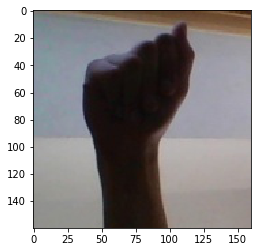

In [4]:
x,_ = next(iter(loader))
plt.imshow(np.transpose(x[0].numpy(), (1, 2, 0)))

In [5]:
def tconv_section(inp,out,*args,**kargs):
    return nn.Sequential(
        nn.ConvTranspose2d(inp,out,*args,**kargs),
        nn.BatchNorm2d(out),
        nn.ReLU()
    )
def tconv_block(a,*args,**kargs):
    layers = [tconv_section(i,j,*args,**kargs) for i,j in zip(a,a[1:])]
    return nn.Sequential(*layers)

In [6]:
tconv_block([3,16,32,64], kernel_size=3, padding=1)

Sequential(
  (0): Sequential(
    (0): ConvTranspose2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (1): Sequential(
    (0): ConvTranspose2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (2): Sequential(
    (0): ConvTranspose2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
)

In [7]:
def to_rgb(in_size,*args,**kargs):
    out =3
    return nn.Sequential(
        nn.ConvTranspose2d(inp,out,*args,**kargs),
        nn.ReLU()
    )

In [8]:
class Generator(nn.Module):
    def __init__(self):
        super(Generator,self).__init__()
        self.dict = nn.ModuleDict({
            'layer_1': tconv_block([3,16,32,64], kernel_size=3, padding=1),
            'Upsample': nn.Upsample(scale_factor=2, mode='nearest'),
            'to_rgb_1': to_rgb(64,kernel_size=3, padding=1)
        })
    def grow(self,n,*args):
        self.dict['layer_{}'.format(n)] = tconv_block(args, kernel_size=3, padding=1)
        self.dict['to_rgb_{}'.format(n)] = to_rgb(args[-1], kernel_size=3, padding=1)
    
    def train_g(self,x,n,aplha):
        x = x.view(-1,10,10)
        for i in range(n):
            if i == 0:
                x = self.dict['layer_{}'.format(i)](x)
            elif i+1 == n:
                x = self.dict['Upsample'](x)
                out = self.dict['layer_{}'.format(i)](x)
                out = self.dict['to_rgb_{}'.format(i)](out)
                x = self.dict['to_rgb_{}'.format(i-1)](x)
                x = (1-aplha)*x + aplha*(out)
            else:
                x = self.dict['Upsample'](x)
                x = self.dict['layer_{}'.format(i)](x)
            
        return x
                
    def forward(self,x,n):
        for i in range(n):
            if i == 0:
                x = self.dict['layer_{}'.format(i)](x)
            else:
                x = self.dict['Upsample'](x)
                x = self.dict['layer_{}'.format(i)](x)
                
        return x

In [42]:
def conv_section(inp,out,*args,**kargs):
    return nn.Sequential(
        nn.Conv2d(inp,out,*args,**kargs),
        nn.BatchNorm2d(out),
        nn.LeakyReLU(negative_slope=0.1)
    )
def conv_block(a,*args,**kargs):
    layers = [conv_section(i,j,*args,**kargs) for i,j in zip(a,a[1:])]
    return nn.Sequential(*layers)

def from_rgb(out,*args,**kargs):
    in_size = 3
    return nn.Sequential(
        nn.Conv2d(in_size,out,*args,**kargs),
        nn.BatchNorm2d(out),
        nn.LeakyReLU(negative_slope=0.1)
    )

In [166]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator,self).__init__()
        self.down = nn.AvgPool2d(kernel_size=2)
        self.dict = nn.ModuleDict({
            'layer_1': conv_block([64,32,16,1], kernel_size=3, padding=1),
            'Upsample': nn.Upsample(scale_factor=2, mode='nearest'),
            'from_rgb_1': from_rgb(64,kernel_size=3, padding=1)
        })
        self.linear = nn.Linear(100,1)
        self.sigmoid = nn.Sigmoid()
        
    def grow(self,n,*args):
        rgb = args[0][0] # because its a tuple
        self.dict['layer_{}'.format(n)] = conv_block(args[0], kernel_size=3, padding=1)
        self.dict['from_rgb_{}'.format(n)] = from_rgb(rgb, kernel_size=3, padding=1)
        
    def train_d(self,x,n,alpha):
        for i in range(n,0,-1):
            if n == 1:
                x = self.dict['from_rgb_{}'.format(n)](x)
                x = self.dict['layer_{}'.format(n)](x)
            elif i == n:
                store = self.dict['from_rgb_{}'.format(n-1)](self.down(x))
                x = self.dict['from_rgb_{}'.format(n)](x)
                x = self.dict['layer_{}'.format(n)](x)
                x = self.down(x)
            elif i == n-1:
                x = (1-alpha)*x + alpha*(store)
                x = self.dict['layer_{}'.format(i)](x)
            else:
                x = self.dict['layer_{}'.format(i)](x)
                x = self.down(x)
        
        x = x.view(-1,100)
        x = self.sigmoid(self.linear(x))
                
        return x
    
    def downSample(self,x,n):
        for i in range(n):
            x = self.down(x)
            
        return x
                

In [167]:
D = Discriminator()

In [168]:
y = D.downSample(x,4)

torch.Size([16, 3, 10, 10])


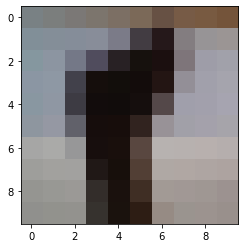

In [169]:
print(y.shape)
plt.imshow(np.transpose(y[0].numpy(), (1, 2, 0)))

In [170]:
D.train_d(y,1,0.9)

tensor([[0.4877],
        [0.4533],
        [0.4089],
        [0.3350],
        [0.4126],
        [0.4116],
        [0.4022],
        [0.3862],
        [0.3781],
        [0.3746],
        [0.3810],
        [0.3854],
        [0.3966],
        [0.4136],
        [0.4032],
        [0.4031]], grad_fn=<SigmoidBackward>)

torch.Size([16, 3, 20, 20])


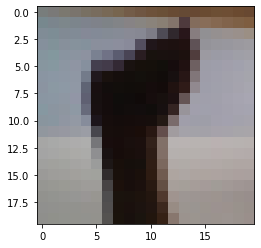

In [171]:
y = D.downSample(x,3)
print(y.shape)
plt.imshow(np.transpose(y[0].numpy(), (1, 2, 0)))
D.grow(2,[256,128,64])

In [172]:
D.train_d(y,2,0.9)

tensor([[0.5043],
        [0.4606],
        [0.4253],
        [0.3350],
        [0.4022],
        [0.4012],
        [0.3880],
        [0.3707],
        [0.3633],
        [0.3604],
        [0.3703],
        [0.3725],
        [0.3850],
        [0.4311],
        [0.3945],
        [0.3988]], grad_fn=<SigmoidBackward>)

torch.Size([16, 3, 40, 40])


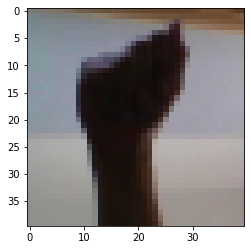

In [173]:
y = D.downSample(x,2)
print(y.shape)
plt.imshow(np.transpose(y[0].numpy(), (1, 2, 0)))
D.grow(3,[1024,512,256])

In [174]:
D.train_d(y,3,0.9)

tensor([[0.6132],
        [0.5473],
        [0.5727],
        [0.5226],
        [0.4798],
        [0.4875],
        [0.5013],
        [0.4994],
        [0.5036],
        [0.5021],
        [0.4901],
        [0.4893],
        [0.4892],
        [0.5748],
        [0.4921],
        [0.5084]], grad_fn=<SigmoidBackward>)